In [1]:
import tensorflow as tf
import sklearn as sk 
import matplotlib.pyplot as plt
import cv2 as cv 
import keras 
import os 
import pandas as pd
from PIL import Image
import itertools 
from sklearn.datasets import *
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model 
import random 
from keras.layers import *
import numpy as np
from datasets import Dataset

d:\Learning\Custom\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


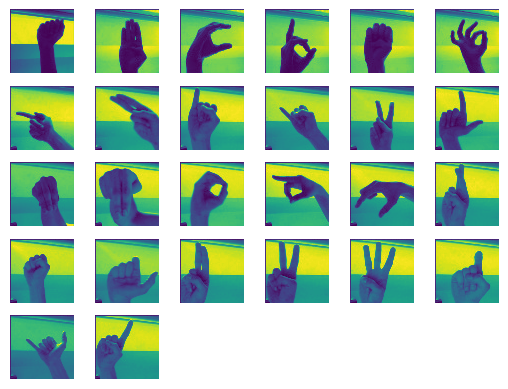

In [2]:
path = "./data/imgs/compress/test/"
n = len(os.listdir(path)) 
for i in os.listdir(path): 
    if i[0].isupper(): 
        img = plt.imread(path+i)
        plt.subplot(5,6,ord(i.split("_")[0])-64)
        plt.axis(False) 
        plt.imshow(img) 
 

In [3]:
csv = {
    "test":pd.read_csv("data/annotations/compress_gray/test.csv"),
    "train":pd.read_csv("data/annotations/compress_gray/train.csv"),
    "valid":pd.read_csv("data/annotations/compress_gray/valid.csv") 
} 

In [4]:
csv["train"][:5]
 

,image_path,label,x_min,y_min,x_max,y_max
0,./data/imgs/compress/train/A\A1.jpg,A,0,0,64,64
1,./data/imgs/compress/train/A\A10.jpg,A,0,0,64,64
2,./data/imgs/compress/train/A\A100.jpg,A,0,0,64,64
3,./data/imgs/compress/train/A\A1000.jpg,A,0,0,64,64
4,./data/imgs/compress/train/A\A1001.jpg,A,0,0,64,64


In [5]:
csv["valid"][:5]

,image_path,label,x_min,y_min,x_max,y_max
0,./data/imgs/compress/valid/A\A0001_test.jpg,A,0,0,64,64
1,./data/imgs/compress/valid/A\A0002_test.jpg,A,0,0,64,64
2,./data/imgs/compress/valid/A\A0003_test.jpg,A,0,0,64,64
3,./data/imgs/compress/valid/A\A0004_test.jpg,A,0,0,64,64
4,./data/imgs/compress/valid/A\A0005_test.jpg,A,0,0,64,64


In [6]:
csv["test"][:5]

,image_path,label,x_min,y_min,x_max,y_max
0,./data/imgs/compress/test/A_test.jpg,A,0,0,64,64
1,./data/imgs/compress/test/B_test.jpg,B,0,0,64,64
2,./data/imgs/compress/test/C_test.jpg,C,0,0,64,64
3,./data/imgs/compress/test/del_test.jpg,del,0,0,64,64
4,./data/imgs/compress/test/D_test.jpg,D,0,0,64,64


In [7]:
tensor = {
    "train": ...,
    "test": ..., 
    "valid": ..., 
} 
path = {
    "train":".\\data\\imgs\\compress\\train",
    "test":".\\data\\imgs\\compress\\test", 
    "valid":".\\data\\imgs\\compress\\valid" 
} 
classes = []
 

In [8]:
image_height = 64
image_width = 64
batch_size = 32

In [9]:

def create_dataset(directory):
    return keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=(image_height, image_width),
        batch_size=batch_size,
        color_mode='grayscale',
        label_mode='categorical' if directory != path["test"] else None,
        shuffle=True if directory == path["train"] else False,
        seed=42,
    )


In [10]:

# Create DataFrame for test images
test_filenames = os.listdir(path["test"])
test_df = pd.DataFrame({
    'filename': test_filenames
})



In [11]:

# Create datasets for train, valid, and test sets
train_dataset = create_dataset(path["train"])
valid_dataset = create_dataset(path["valid"])
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = Dataset.from_pandas(test_df)

Found 87000 files belonging to 29 classes.
Found 870 files belonging to 29 classes.


In [12]:
tensor["train"] = train_dataset
tensor["valid"] = valid_dataset
tensor["test"] = test_dataset

In [13]:
def _prefetch_to_tensor(dataset):
    dataset = dataset.take(1)
    np_arr = next(iter(dataset))
    t = tf.convert_to_tensor(np_arr)
    return t

In [14]:
train = list(tensor["train"])
valid = list(tensor["valid"])

In [67]:
train[0]

(<tf.Tensor: shape=(32, 64, 64, 1), dtype=float32, numpy=
 array([[[[ 26.],
          [ 29.],
          [ 27.],
          ...,
          [ 31.],
          [ 32.],
          [ 33.]],
 
         [[ 29.],
          [ 77.],
          [ 82.],
          ...,
          [ 74.],
          [129.],
          [140.]],
 
         [[ 28.],
          [ 53.],
          [ 51.],
          ...,
          [145.],
          [134.],
          [135.]],
 
         ...,
 
         [[ 38.],
          [168.],
          [166.],
          ...,
          [123.],
          [123.],
          [125.]],
 
         [[ 35.],
          [164.],
          [163.],
          ...,
          [120.],
          [123.],
          [124.]],
 
         [[ 34.],
          [165.],
          [163.],
          ...,
          [116.],
          [121.],
          [123.]]],
 
 
        [[[ 25.],
          [ 26.],
          [ 30.],
          ...,
          [ 26.],
          [ 30.],
          [ 33.]],
 
         [[ 28.],
          [ 83.],
     

In [68]:
def convert(data: list[tuple[tf.Tensor,tf.Tensor]]):
    nparr = []
    nplabel = []
    for i in data:
        for x in i[0]:
            nparr.append(tf.squeeze(x).numpy())
        for y in i[1]:
            nplabel.append(y.numpy())
    arr = np.array(nparr)
    labels = np.array(nplabel)
    return arr, labels

In [91]:
train_data,train_labels = convert(train)
valid_data,valid_labels = convert(valid)

In [92]:
train_data.shape,train_labels.shape, valid_data.shape,valid_labels.shape

((87000, 64, 64), (87000, 29), (870, 64, 64), (870, 29))

In [98]:
# Normalize
norm_train = train_data/255.0
norm_valid = valid_data/255.0
norm_train[:5],norm_valid[:5]

(array([[[0.10196079, 0.11372549, 0.10588235, ..., 0.12156863,
          0.1254902 , 0.12941177],
         [0.11372549, 0.3019608 , 0.32156864, ..., 0.2901961 ,
          0.5058824 , 0.54901963],
         [0.10980392, 0.20784314, 0.2       , ..., 0.5686275 ,
          0.5254902 , 0.5294118 ],
         ...,
         [0.14901961, 0.65882355, 0.6509804 , ..., 0.48235294,
          0.48235294, 0.49019608],
         [0.13725491, 0.6431373 , 0.6392157 , ..., 0.47058824,
          0.48235294, 0.4862745 ],
         [0.13333334, 0.64705884, 0.6392157 , ..., 0.45490196,
          0.4745098 , 0.48235294]],
 
        [[0.09803922, 0.10196079, 0.11764706, ..., 0.10196079,
          0.11764706, 0.12941177],
         [0.10980392, 0.3254902 , 0.3254902 , ..., 0.31764707,
          0.54901963, 0.5764706 ],
         [0.11372549, 0.21568628, 0.2       , ..., 0.5568628 ,
          0.5568628 , 0.54901963],
         ...,
         [0.14509805, 0.68235296, 0.6784314 , ..., 0.5058824 ,
          0.50980395, 0.

In [101]:
int_train_labels = np.argmax(train_labels,axis=1)
int_valid_labels = np.argmax(valid_labels,axis=1)
int_train_labels.shape,int_valid_labels.shape

((87000,), (870,))

In [110]:
model = keras.Sequential([
    keras.Input(shape=(64, 64, 1)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(29, activation='softmax')

])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.3),

              loss='sparse_categorical_crossentropy',

              metrics=['accuracy'],)


model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,511,261 (24.84 MB)

 Trainable params: 6,511,261 (24.84 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
from keras.callbacks import TensorBoard
import datetime

In [114]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
%load_ext tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(norm_train,
                    int_train_labels,
                    validation_data=(
                        norm_valid,
                        int_valid_labels
                        ), 
                    epochs=10)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/10
 858/2719 ━━━━━━━━━━━━━━━━━━━━ 3:47 122ms/step - accuracy: 0.0334 - loss: 3.4406

KeyboardInterrupt: 

In [ ]:
%reload_ext tensorboard

In [105]:

pd.DataFrame(history.history).plot()

NameError: name 'history' is not defined